# DeepInsight SqueezeNet Example

This example shows a case of using the output of 
pyDeepInsight.ImageTransformer to train a SqueezeNet model
using PyTorch. This follows the general approach used in the
original DeepInsight paper.

## DeepInsight

In [1]:
from pyDeepInsight import ImageTransformer
from pyDeepInsight.utils import Norm2Scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

Load example TCGA data and split into training and testing sets

In [2]:
expr_file = r"./data/curatedTCGAData_RNASeq2GeneNorm-20160128.txt.gz"
expr = pd.read_csv(expr_file, sep="\t")
y = expr['cancer'].values
X = expr.iloc[:, 2:].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)

In [3]:
np.unique(y, return_counts=True)

(array(['BRCA', 'HNSC', 'KIRC', 'LGG', 'LUAD', 'LUSC', 'THCA', 'UCEC'],
       dtype=object),
 array([1093,  520,  533,  516,  515,  501,  501,  371]))

Normalize data using LogScaler and encode classes

In [4]:
ln = Norm2Scaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

In [5]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = np.unique(y_train_enc).size

Create t-SNE object

In [6]:
distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1
)

Initialize image transformer.

In [7]:
pixel_size = (227,227)
it = ImageTransformer(
    feature_extractor=reducer, 
    pixels=pixel_size)

Train image transformer on training data and transform training 
and testing sets. Values should be between 0 and 1.

/home/keith/mnt/crux/projects/PycharmProjects/pyDeepInsight/pyDeepInsight/image_transformer.py:270: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_new[:, 0], x_new[:, 1], s=1,


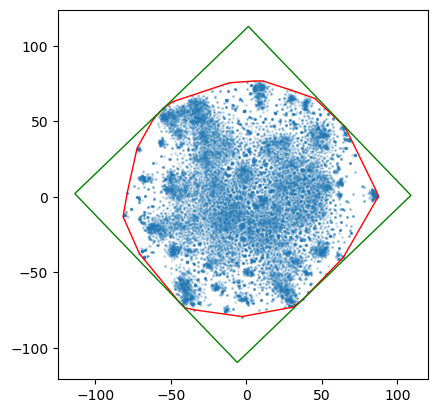

In [8]:
it.fit(X_train, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

The feature density matrix can be extracted from the trained transformer in order to view overall feature overlap.

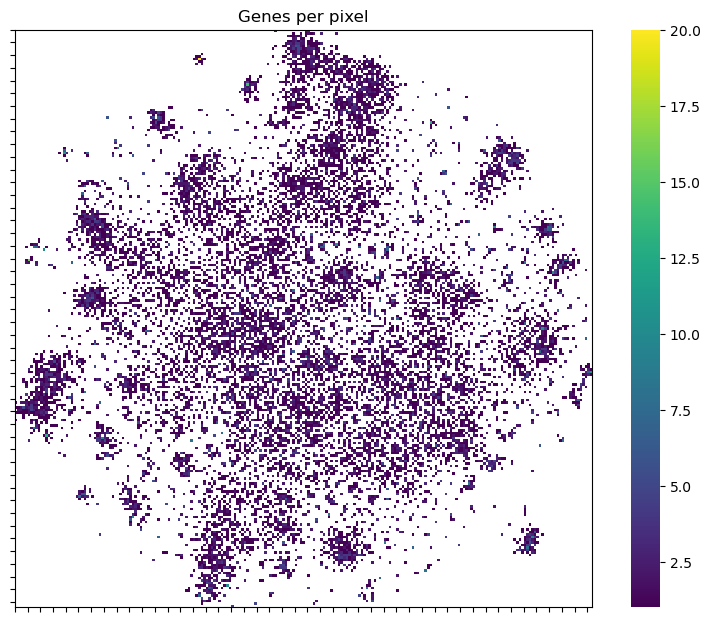

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7.5))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0., 
                 linecolor="lightgrey", square=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
for _, spine in ax.spines.items():
    spine.set_visible(True)
_ = plt.title("Genes per pixel")

The following are showing plots for the image matrices first four samples 
of the training set. 

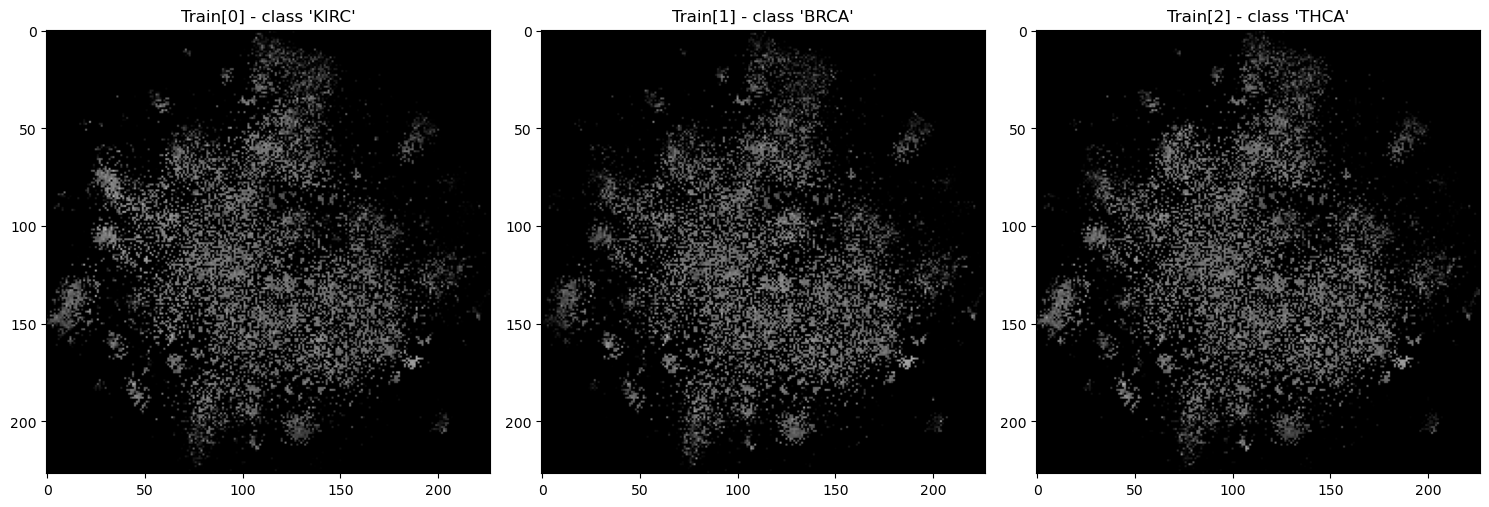

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text(f"Train[{i}] - class '{y_train[i]}'")
plt.tight_layout()

Transforming the testing data is done the same as transforming the 
training data.

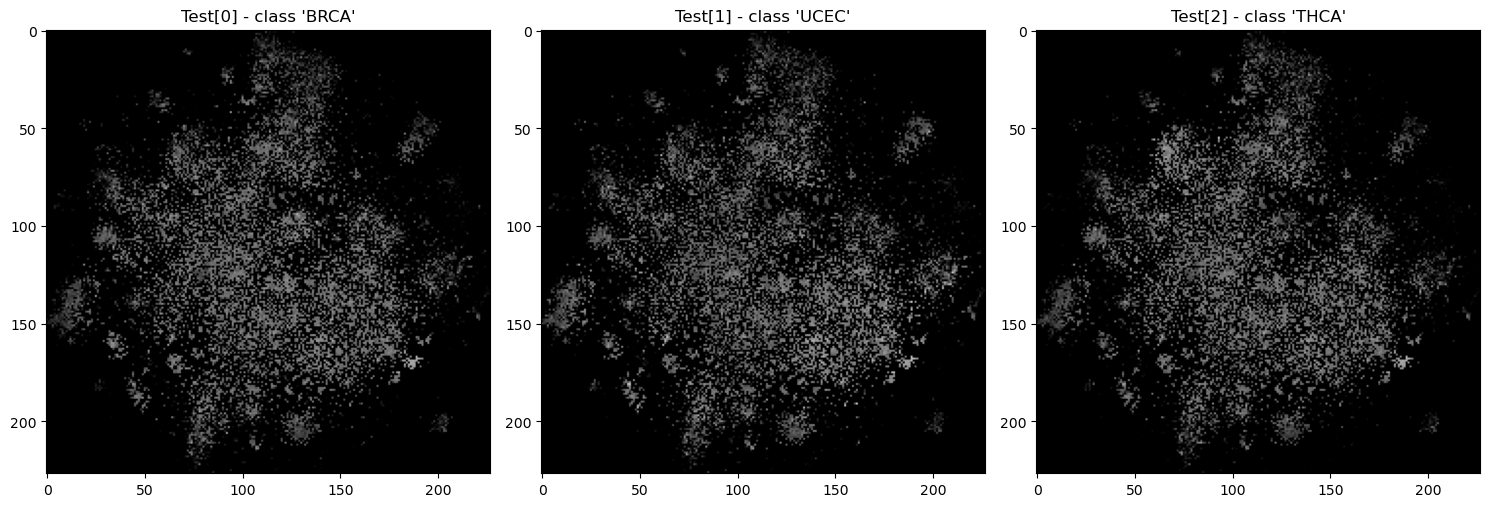

In [11]:
X_test_img = it.transform(X_test_norm)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_test_img[i])
    ax[i].title.set_text(f"Test[{i}] - class '{y_test[i]}'")
plt.tight_layout()

## SqueezeNet

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import warnings; 
warnings.simplefilter('ignore')

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Modify [PyTrorch SqueezeNet 1.1][1] output to number of classes

[1]: https://pytorch.org/vision/stable/models/squeezenet.html

In [14]:
model = torchvision.models.squeezenet1_1(weights='DEFAULT')
model.classifier.append(nn.Flatten())
_ = model.classifier.append(nn.Linear(1000, num_classes))

Transform numpy image format to PyTorch tensor. Using an untrained network,
so normalization as specificed in SqueezeNet documentation is not 
required.


In [15]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

In [16]:
X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float()
y_train_tensor = torch.from_numpy(le.fit_transform(y_train))

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float()
y_test_tensor = torch.from_numpy(le.transform(y_test))

Generate pyTorch datasets and dataloaders for training and testing sets.

In [17]:
batch_size = 200

trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Specify loss function and optimization algorithm

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-04,
    #momentum=0.8,
    weight_decay=1e-05
)

Train SqueezeNet for 120 epochs

In [19]:
model.train()
model.to(device)
for epoch in range(120):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')
print(f'[{epoch}] loss: {running_loss / len(X_train_tensor) * batch_size:.3f}')

[0] loss: 2.251
[20] loss: 0.103
[40] loss: 0.043
[60] loss: 0.050
[80] loss: 0.014
[100] loss: 0.004
[119] loss: 0.006


Calculate accuracy of prediction

In [20]:
model.to('cpu')
model = model.eval()

In [21]:
with torch.no_grad():
    y_hat = model(X_train_tensor)
train_predicted = torch.max(y_hat, 1)[1]

In [22]:
with torch.no_grad():
    y_hat = model(X_test_tensor)
test_predicted = torch.max(y_hat, 1)[1]

In [23]:
print(f"The train accuracy was {accuracy_score(train_predicted, y_train_tensor):.3f}")
print(f"The test accuracy was {accuracy_score(test_predicted, y_test_tensor):.3f}")

The train accuracy was 0.999
The test accuracy was 0.979


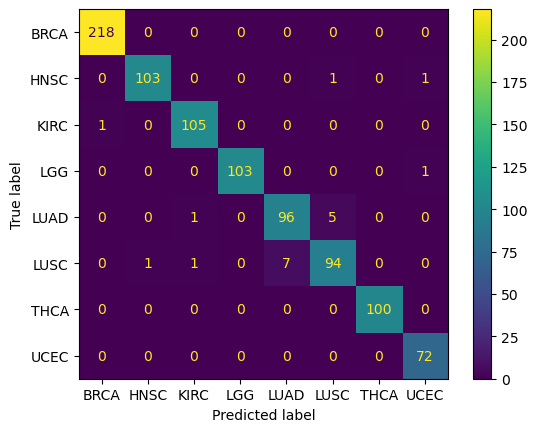

In [24]:
_ = ConfusionMatrixDisplay.from_predictions(test_predicted, y_test_tensor, display_labels=le.classes_)